# 6. Time series analysis
Lets decompose the hourly electricity demand into three additive components:
- trend
- season
- residual

## Setup and imports


In [1]:
from functions import *
academic_style()

## Load the data

In [2]:
df = load_data()
demand = (
    df["demand"]
    .resample("h")
    .mean()
    .interpolate(method="time", limit_direction="both")
    .dropna()
)

print("Hourly demand series prepared")
print("Time span:", demand.index.min(), "->", demand.index.max())
print("Length:", len(demand))


Hourly demand series prepared
Time span: 2013-07-01 00:00:00+00:00 -> 2014-06-30 23:00:00+00:00
Length: 8760


## Classical additive decomposition at multiple time scales

In [3]:
stl_24h_result, stl_24h = decompose_series(demand, period=24)

daily_mean = demand.resample("D").mean()

stl_7d_result, stl_7d = decompose_series(daily_mean, period=7)
stl_365d_result, stl_365d = decompose_series(daily_mean, period=365, seasonal=31)

## Quantifying seasonality strength

In [4]:
seasonality_results = pd.DataFrame([
    {"Period": "24h",  "Component": "Seasonal", "Strength": seasonality_strength(stl_24h_result.resid,  stl_24h_result.seasonal)},
    {"Period": "24h",  "Component": "Trend",    "Strength": seasonality_strength(stl_24h_result.resid,  stl_24h_result.trend)},
    {"Period": "7d",   "Component": "Seasonal", "Strength": seasonality_strength(stl_7d_result.resid,   stl_7d_result.seasonal)},
    {"Period": "7d",   "Component": "Trend",    "Strength": seasonality_strength(stl_7d_result.resid,   stl_7d_result.trend)},
    {"Period": "365d", "Component": "Seasonal", "Strength": seasonality_strength(stl_365d_result.resid, stl_365d_result.seasonal)},
])

seasonality_results["Strength"] = seasonality_results["Strength"].round(3)

seasonality_results["Explained_%"] = (seasonality_results["Strength"] * 100).round(1)

seasonality_results.to_csv(TABLES_DIR + "seasonality_strength.csv", index=False)

seasonality_results


,Period,Component,Strength,Explained_%
0,24h,Seasonal,0.242,24.2
1,24h,Trend,0.107,10.7
2,7d,Seasonal,0.221,22.1
3,7d,Trend,0.448,44.8
4,365d,Seasonal,1.000,100.0


## STL visualisation (24h window)

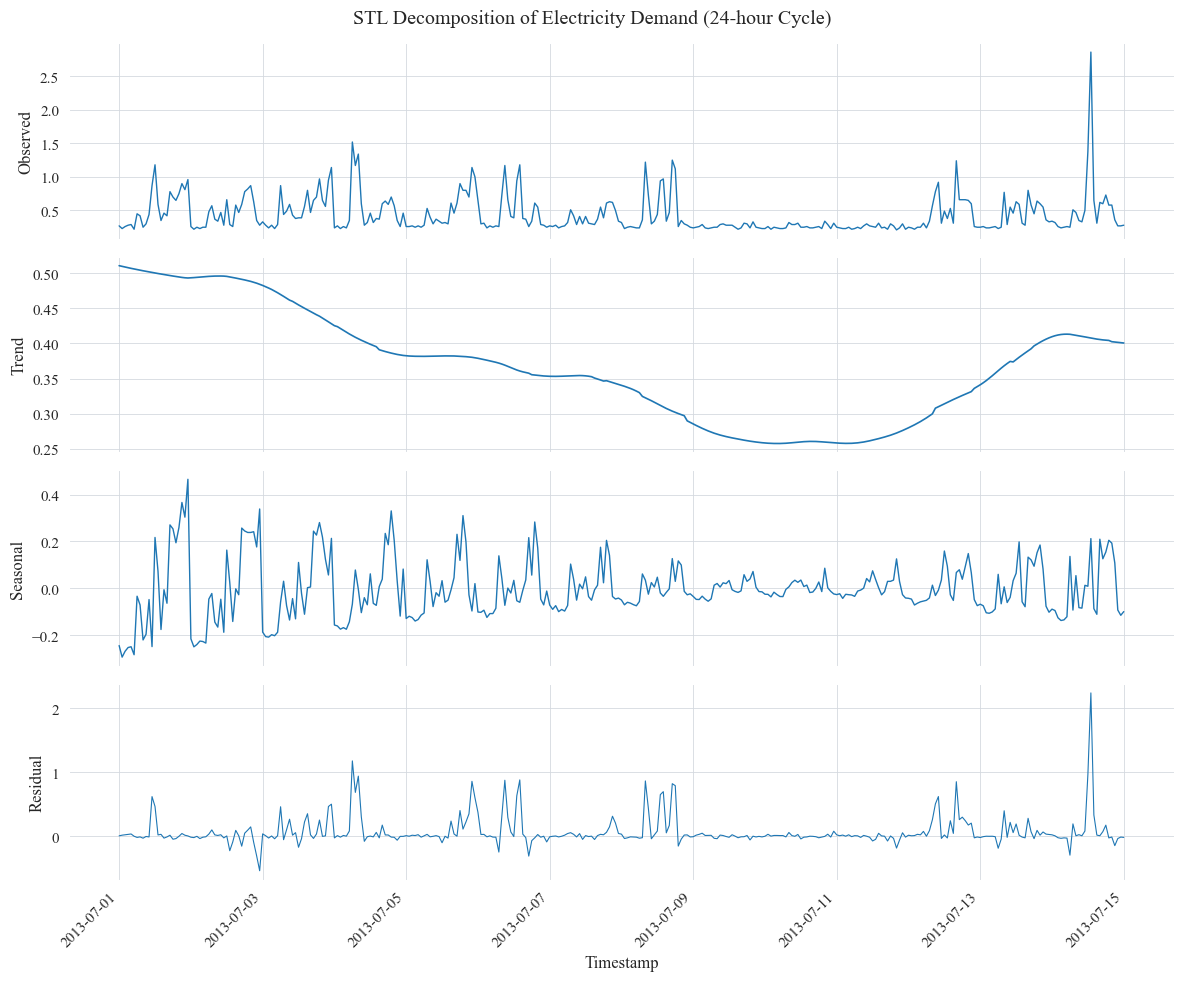

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

start = stl_24h.index.min()
end = start + pd.Timedelta(days=14)

subset = stl_24h.loc[start:end]
subset_obs = demand.loc[start:end]

ax[0].plot(subset_obs, linewidth=1.0)
ax[0].set_ylabel("Observed")

ax[1].plot(subset["trend"], linewidth=1.2)
ax[1].set_ylabel("Trend")

ax[2].plot(subset["seasonal"], linewidth=1.0)
ax[2].set_ylabel("Seasonal")

ax[3].plot(subset["residual"], linewidth=0.8)
ax[3].set_ylabel("Residual")
ax[3].set_xlabel("Timestamp")

for a in ax:
    plt.setp(a.xaxis.get_majorticklabels(), rotation=45, ha="right")

fig.suptitle("STL Decomposition of Electricity Demand (24-hour Cycle)")
fig.tight_layout()

save_fig(fig, "ex6_fig1_stl_decomposition.svg")
plt.show()


---
## 3. Typical demand profiles

- Average hourly demand of each month

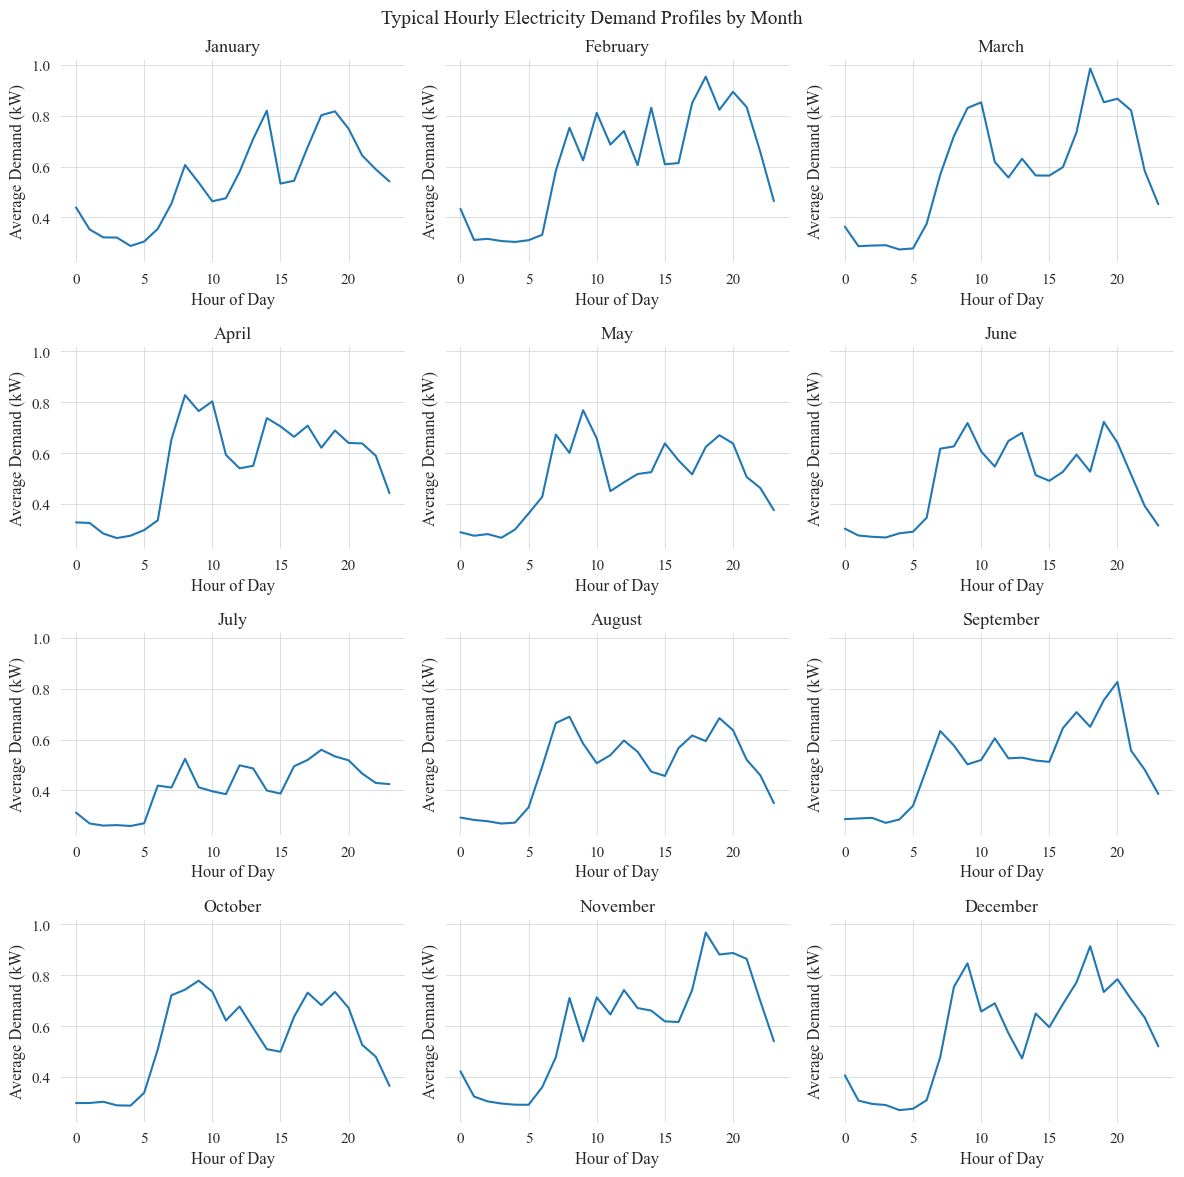

In [6]:
demand_df = demand.to_frame(name="demand")

demand_df["month"] = demand_df.index.month
demand_df["hour"] = demand_df.index.hour

month_labels = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

monthly_avg = (
    demand_df
    .groupby(["month", "hour"])["demand"]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month - 1]
    month_data = monthly_avg[monthly_avg["month"] == month]

    ax.plot(month_data["hour"], month_data["demand"], linewidth=1.5)
    ax.set_title(month_labels[month - 1])
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Average Demand (kW)")
    ax.grid(True)

fig.suptitle("Typical Hourly Electricity Demand Profiles by Month", fontsize=14)
plt.tight_layout()
save_fig(fig, "ex6_fig_2_hourly_demand_for_each_month.svg")
plt.show()


- Average hourly demand by season

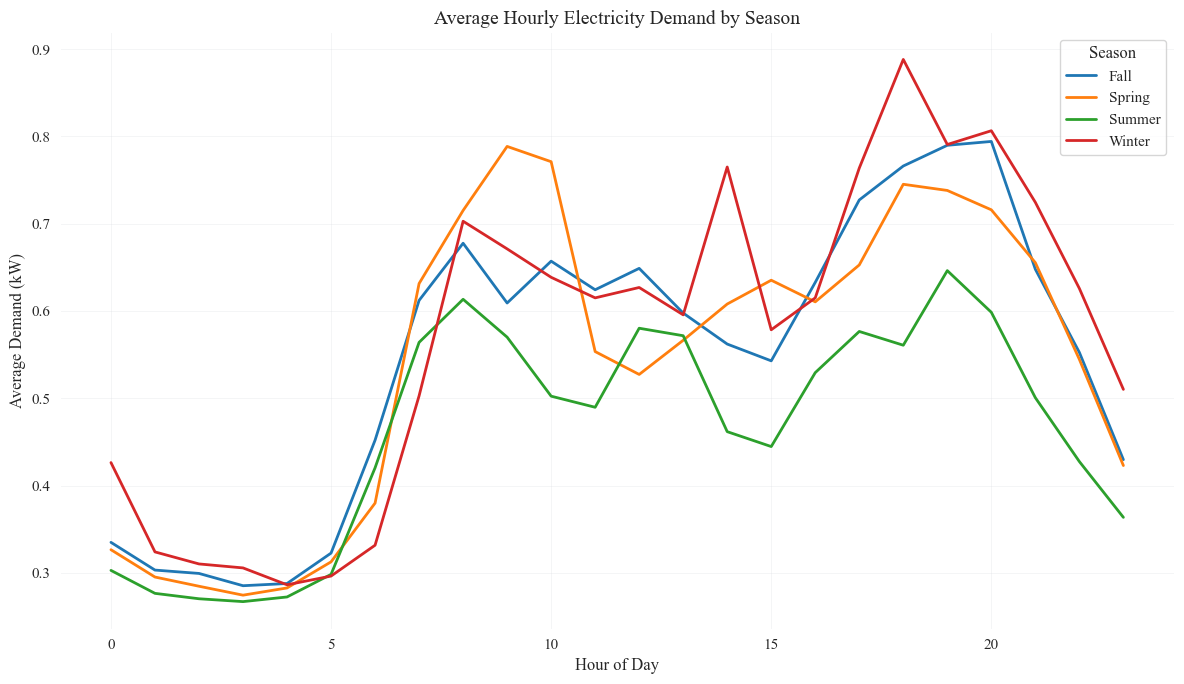

In [8]:
demand_df["season"] = demand_df["month"].apply(get_season)

# Keskmine tunniprofiil hooajati
seasonal_profiles = (
    demand_df
    .groupby(["hour", "season"])["demand"]
    .mean()
    .unstack("season")
)

fig = plt.figure(figsize=(12, 7))
seasonal_profiles.plot(ax=plt.gca(), linewidth=2)

plt.title("Average Hourly Electricity Demand by Season", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Demand (kW)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Season")

plt.tight_layout()
save_fig(fig, "ex6_fig_3_hourly_demand_by_season.svg")
plt.show()

- Average hourly demand - weekday vs weekend

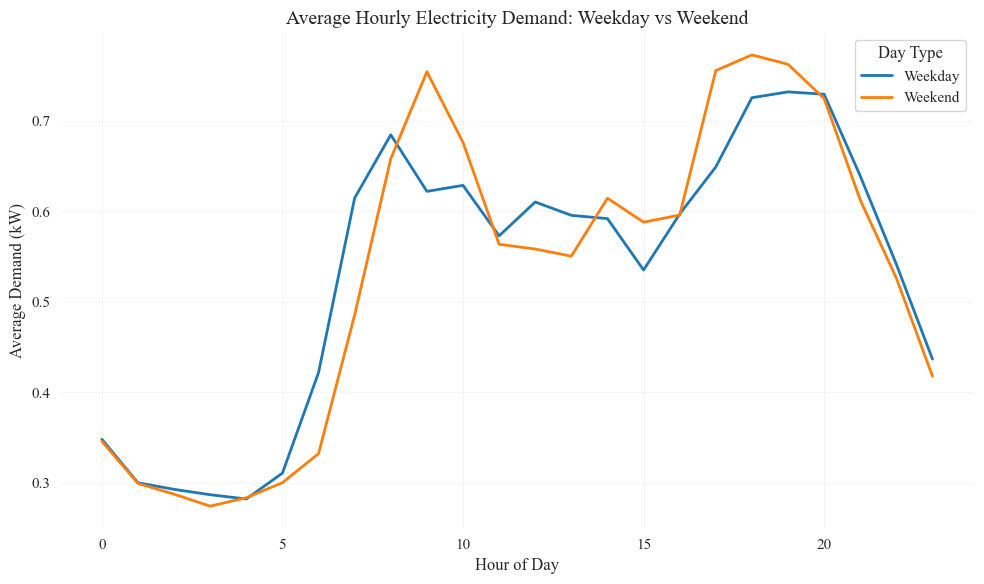

In [9]:
demand_df["day_of_week"] = demand_df.index.dayofweek
demand_df["is_weekend"] = demand_df["day_of_week"] >= 5
demand_df["day_type"] = demand_df["is_weekend"].map({False: "Weekday", True: "Weekend"})

# Keskmine tunniprofiil päevatüübi järgi
weekday_profile = (
    demand_df
    .groupby(["hour", "day_type"])["demand"]
    .mean()
    .unstack("day_type")
)

fig = plt.figure(figsize=(10, 6))
weekday_profile.plot(ax=plt.gca(), linewidth=2)

plt.title("Average Hourly Electricity Demand: Weekday vs Weekend", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Demand (kW)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Day Type")

plt.tight_layout()
save_fig(fig, "ex6_fig_4_hourly_demand_weekday_vs_weekend.svg")
plt.show()


---
## 4. Methodology Explanation
Hourly electricity demand data were indexed by timestamp and converted to a continuous hourly frequency.
Small gaps were filled by interpolation to ensure data completeness.
Time-based features — *month*, *hour*, *day*, *season*, and *weekday/weekend* — were extracted from the index.

**Monthly Profiles:**
The data were grouped by month and hour (`groupby(['month','hour'])`) to calculate the mean hourly demand for each month.
This produced 12 average daily profiles, one for each month, visualized as separate subplots.

**Seasonal Profiles:**
A seasonal label was assigned to each observation using the `get_season()` function.
Average hourly demand for each season was computed (`groupby(['hour','season'])`) and plotted on a single chart to highlight seasonal variation.

**Weekday vs Weekend:**
Each timestamp was classified as either a weekday or weekend based on `day_of_week`.
Average hourly demand for both categories was compared to reveal behavioural differences in daily usage patterns.

**Purpose:**
These profiles illustrate how typical electricity consumption changes by month, season, and day type,
supporting better understanding of temporal demand patterns for forecasting.